In [112]:
import numpy as np
import pandas as pd
import keras as ks
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.utils import pad_sequences
from sklearn.metrics import precision_recall_curve
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

train = pd.read_csv('/content/training_dataset.csv')
test = pd.read_csv('/content/testing_dataset.csv')
#Importing necessary packages and files

In [113]:
train=train.astype(str)
test=test.astype(str)

max_words = 5000
#max words denotes the max number that can be converted to

max_len = 16
#max len denotes the no of words in a tweet to be represented as token

In [114]:
train_labels = train['Sentiment'].values
train_labels = ks.utils.to_categorical(train_labels,4,dtype="float32")
vectorizer = layers.TextVectorization(max_tokens=max_words, output_mode='int', output_sequence_length=max_len)
vectorizer.adapt(train['tidy_tweet'])
train_vectorized = vectorizer(train['tidy_tweet'])

In [115]:
test_labels = test['Sentiment'].values
test_labels = ks.utils.to_categorical(test_labels,4,dtype="float32")
test_vectorized= vectorizer(test['tidy_tweet'])

Replaced the previous tweet processing code with Keras Text Vectorization

In [116]:
X_train,X_test,y_train,y_test=train_test_split(train_vectorized.numpy(),train_labels, test_size=0.2)
#Splitting training data with 80:20 split

In [117]:
def modelbuild():
  model = ks.models.Sequential()
  model.add(layers.Embedding(max_words,32,input_length=max_len))
  model.add(layers.Conv1D(32,4, padding='same', activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.LSTM(32))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(optimizer='Adam',loss="categorical_crossentropy",metrics=["accuracy"],)
  return model
#Neural Network Model

In [118]:
print("New Model y/n?")
c=input()
if c == 'y':
  model=modelbuild()
else:
  model=ks.models.load_model('/content/models')

New Model y/n?
y


In [119]:
stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
#safety to prevent overfitting, when val loss increases and restores the weights

In [127]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[stop])
#training the model

Epoch 1/10
2254/2254 [==============================] - 35s 15ms/step - loss: 0.3064 - accuracy: 0.8900 - val_loss: 0.5915 - val_accuracy: 0.8063
Epoch 2/10
2254/2254 [==============================] - 33s 15ms/step - loss: 0.2649 - accuracy: 0.9042 - val_loss: 0.5964 - val_accuracy: 0.8235
Epoch 3/10
2254/2254 [==============================] - 35s 16ms/step - loss: 0.2355 - accuracy: 0.9140 - val_loss: 0.6083 - val_accuracy: 0.8263
Epoch 3: early stopping


In [128]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy on validation data: ',test_acc)

564/564 - 3s - loss: 0.5915 - accuracy: 0.8063 - 3s/epoch - 5ms/step
Model accuracy on validation data:  0.8063335418701172


In [129]:
test_loss, test_acc = model.evaluate(test_vectorized.numpy(),test_labels, verbose=1)
print('Model accuracy on testing data: ',test_acc)
print("Want to save model?")
c=input()
if c=='y':
  ks.Model.save(model,'/content/models')

32/32 [==============================] - 0s 5ms/step - loss: 0.2671 - accuracy: 0.9240
Model accuracy on testing data:  0.9240000247955322
Want to save model?
y


In [136]:
y_pred=model.predict(X_test)
max_idx = np.arange(y_pred.shape[0]), np.argmax(y_pred, axis=1)
bool_array = np.zeros_like(y_pred)
bool_array[max_idx] = 1

564/564 [==============================] - 3s 5ms/step


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      5160
           1       0.87      0.77      0.82      5308

   micro avg       0.83      0.80      0.82     10468
   macro avg       0.83      0.80      0.82     10468
weighted avg       0.83      0.80      0.82     10468
 samples avg       0.47      0.47      0.47     10468



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

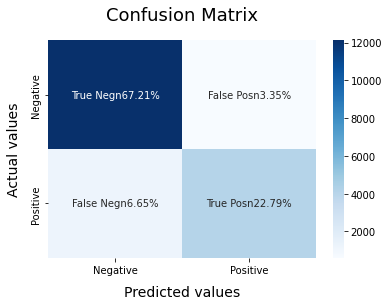

In [137]:
# Print the evaluation metrics for the dataset.

print(classification_report(y_test[:,1:3],bool_array[:,1:3]))
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test[:,1:3].argmax(axis=1),bool_array[:,1:3].argmax(axis=1))
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

32/32 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       266
           1       0.96      0.90      0.93       277

   micro avg       0.94      0.91      0.92       543
   macro avg       0.94      0.91      0.92       543
weighted avg       0.94      0.91      0.92       543
 samples avg       0.49      0.49      0.49       543



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

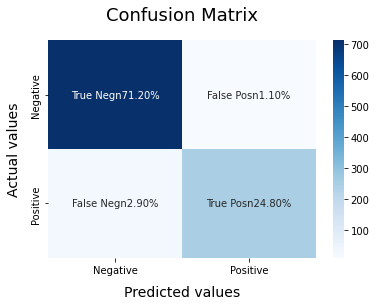

In [139]:
test_pred=model.predict(test_vectorized.numpy())
max_idx = np.arange(test_pred.shape[0]), np.argmax(test_pred, axis=1)
bool_array = np.zeros_like(test_pred)
bool_array[max_idx] = 1


# Print the evaluation metrics for the dataset.

print(classification_report(test_labels[:,1:3],bool_array[:,1:3]))
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(test_labels[:,1:3].argmax(axis=1),bool_array[:,1:3].argmax(axis=1))
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)